In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from snntorch import utils
from snntorch import spikegen

DVS data

In [3]:
from src.io.psee_loader import PSEELoader

import pathlib
from glob import glob

device = 'cpu'

delta_t = 10000
n = 75
skip = 100
n_in = 30

vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

#print(event_seqs[0])

dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

print(train_data.shape, test_data.shape)

(60, 10000, 900) (15, 10000, 900)


In [4]:
batch_size = 4
data_path='/data/mnist'
num_steps=1000
n_in = 30

class RegressionDataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_loader = DataLoader(RegressionDataset(train_data, train_data), batch_size=batch_size)
test_loader  = DataLoader(RegressionDataset(test_data, test_data),  batch_size=batch_size)


In [5]:
# Network Architecture
num_inputs = n_in*n_in
num_hidden = 64
num_outputs = n_in*n_in

# Temporal Dynamics
num_steps = 10000
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step].float())
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        #print(torch.stack(spk2_rec, dim=0))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [6]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    targets = targets.view(batch_size,-1).numpy()
    #_, idx = output.sum(dim=0).max(1)
    #_, idx = output.sum(dim=0).max(1)
    #acc = np.mean((targets == idx).detach().cpu().numpy())
    #print('op',output.shape, targets.shape)
    avg_rate_output = output.mean(axis=0).detach().numpy()
    acc = np.mean((avg_rate_output - targets)**2)

    #acc = np.mean((targets - idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc}")
    else:
        print(f"Test set accuracy for a single minibatch: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [7]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [8]:
num_steps=10000

data, targets = next(iter(train_loader))
data = data.view(num_steps, batch_size, -1).to(device)
targets = data.view(num_steps, batch_size, -1).to(device)

print(data.shape, targets.shape)

spk_rec, mem_rec = net(data.view(num_steps, batch_size, -1))
print(spk_rec.size(), mem_rec.size())

# initialize the total loss value
#loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

torch.Size([10000, 4, 900]) torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([10000, 4, 900])


NameError: name 'loss_val' is not defined

In [9]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
#loss_val.backward()

# weight update
#optimizer.step()

In [10]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = data.to(device)#targets.to(device)
        targets = targets.squeeze(1).view(num_steps,batch_size, -1).float().mean(axis=0)

        spike_data = data

        # Spiking Data
        #spike_data = spikegen.rate(data, num_steps=num_steps)
        #print(spike_data.shape)

        #print(targets.shape)

        # forward pass
        print(spike_data.view(num_steps,batch_size, -1).shape)
        net.train()
        spk_rec, mem_rec = net(spike_data.view(num_steps,batch_size, -1))

        print(spk_rec.shape, targets.shape)

        #print(spk_rec.shape, mem_rec.shape, data.shape, targets.shape)

        # initialize the loss & sum over time
        #loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.mean(axis=0), targets.view(batch_size,-1))
        #for step in range(num_steps):
            #loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_data.to(device)#test_targets.to(device)
            test_targets = test_targets.view(num_steps,batch_size, -1).float().mean(axis=0)

            spike_data_test = test_data

            #spike_data_test = spikegen.rate(data, num_steps=num_steps)

            # Test set forward pass
            test_spk, test_mem = net(spike_data_test.view(num_steps, batch_size, -1))

            # Test set loss
            #test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_loss = loss(test_spk.mean(axis=0), test_targets.view(batch_size,-1))
            #for step in range(num_steps):
                #test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            '''if counter % 50 == 0:
                train_printer()'''
            counter += 1
            iter_counter +=1

torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])
torch.Size([10000, 4, 900])
torch.Size([10000, 4, 900]) torch.Size([4, 900])

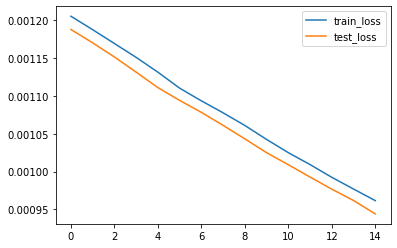

In [11]:
plt.figure()
plt.plot(loss_hist, label='train_loss')
plt.plot(test_loss_hist, label='test_loss')
plt.legend()

torch.Size([4, 10000, 900])


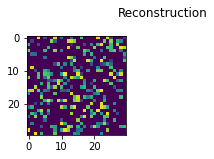

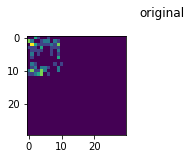

In [12]:
test_data, test_targets = next(iter(test_loader))

plt.figure()
for i in range(1):
    # Integrate through time for each location while displaying final image
    dat = test_data[i,:]
    print(test_data.shape)
    #dat = spikegen.rate(dat, num_steps=num_steps)
    spk_rec, mem_rec = net(dat.view(num_steps, 1, -1))
    final_image = spk_rec.sum(0)[0].detach().numpy()
    #plt.figure()
    #plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((30, 30)))
    plt.suptitle('Reconstruction')
plt.show()

plt.figure(1)
for i in range(1):
    # Integrate through time for each location while displaying final image
    final_image = test_data[i,:].float().mean(axis=0).numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((30, 30)))
    plt.suptitle('original')
plt.show()
  
